### Introduction:

There are also over 1000 biospecimen features in the dataset. The intuition is that without specific domain knowledge, it is hard to capture the signals from these biospecimen features. To confirm that, we do a hypothesis testing here. 

The null hypothesis $H_0$ is: There is no true relationship between the biospecimen features and the UPDRS target scores. The model's performance on the real data is not better than what could be achieved by random chance.

The alternative hypothesis $H_1$ is: There is a true, non-random relationship between the biospecimen features and the UPDRS target scores. The model's performance on the real data is significantly better than what would be expected by random chance.

In [35]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import ColumnTransformer
import re
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

sns.set_style("whitegrid")

Since LGBM model cannot handle special characters such as "/", "+", "(", which appeared in the column name of biospecimen features, we need to replace all the special characters by "_".

In [36]:
data = pd.read_csv("../3. EDA and data preprocessing/preprocessed_training_data.csv")
data.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in data.columns]

with open("../3. EDA and data preprocessing/time_dependent_clinical_features.txt", 'r') as file:
    clinical_feature_time_dependent = file.readlines()
clinical_feature_time_dependent = [item.strip() for item in clinical_feature_time_dependent]

with open("../3. EDA and data preprocessing/static_clinical_features.txt", 'r') as file:
    clinical_feature_non_time_dependent = file.readlines()
clinical_feature_non_time_dependent = [item.strip() for item in clinical_feature_non_time_dependent]


cols=data.columns.tolist()
proteomics_features = []

for i in cols:
  if "CSF" in i or "Plasma" in i or "Serum" in i or "RNA" in i:
    proteomics_features.append(i)

updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']

cols_to_lag = clinical_feature_time_dependent + updrs_cols

data = data.sort_values(['participant_id', 'visit_month'])

for lag in [1, 2, 3]: 
    for col in cols_to_lag:
        data[f'{col}_lag_{lag}'] = data.groupby('participant_id')[col].shift(lag)

lagged_feature_cols = [col for col in data.columns if '_lag_' in col]

clinical_or_lagged_features = clinical_feature_non_time_dependent + lagged_feature_cols

clinical_or_lagged_features = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in clinical_or_lagged_features]

final_feature_cols = clinical_or_lagged_features + proteomics_features

Since imputers will implicitly drop columns where all the values are missing and there is only one such column in the biospeciman feature, we deleted it from the dataframe and features lists.

In [37]:
missing_columns = data.columns[data.isnull().all()]
print(f"there is/are {len(missing_columns)} missing column(s)")
print(f"the missing column(s) is/are:")
for missing_col in missing_columns:
    print(missing_col)
    data=data.drop(missing_col, axis=1)
    while missing_col in final_feature_cols:
        final_feature_cols.remove(missing_col)
    while missing_col in proteomics_features:
        proteomics_features.remove(missing_col)
assert len(data.columns[data.isnull().all()])==0

print(f"there is no missing column after the removal")

there is/are 1 missing column(s)
the missing column(s) is/are:
test_value_CSF_a_syn_ng_mL
there is no missing column after the removal


Besides, duplicated columns will also confuse the LGBM model, and we need to rename them.

In [38]:
duplicated_cols = data.columns[data.columns.duplicated()]
old_number_of_cols = len(data.columns)
print(f"there are/is {len(data.columns)-len(data.columns.unique())} duplicated column(s)")
print(f"the missing column(s) is/are:")
for dup_col in duplicated_cols:
    print(dup_col)
counts = Counter()
new_columns = []
for col in data.columns:
    counts[col] += 1
    if counts[col] > 1:
        new_columns.append(f"{col}_{counts[col]}")
    else:
        new_columns.append(col)

data.columns = new_columns
new_number_of_cols = len(data.columns)
assert (len(data.columns[data.columns.duplicated()])==0) and (old_number_of_cols==new_number_of_cols)
print(f"there is no duplicated column and no data loss after renaming")

there are/is 1 duplicated column(s)
the missing column(s) is/are:
test_value_Plasma_Casein_kinase_II_2_alpha_2_beta_heterotetramer_RFU
there is no duplicated column and no data loss after renaming


### We use the permutation test to do the hypothesis testing, for the following reasons:


1. Little assumptions about the data

    By EDA, we see that there are heterogeneity and highly skewed distributions in the dataset. Since permutation test makes little assumption about the data, it is a robust and reliable choice.

2. Compatibility with the model and cross validation

    LGBM is a complicated model and we used cross validation when we evaluate the error of LGBM trained only on the clinical and lag features. To make the experiment closer to the previous training process, we decide to use cross validation. However, both LGBM and cross validation discourages some traditional ways of hypothesis testing, while the permutation test becomes a good choice in this setting.


In [ ]:
def run_experiment(X, y, groups, feature_cols):
    """
    Runs a cross-validated experiment for a given set of features.
    Handles imputation correctly inside the cross-validation loop.
    Supports multi-output targets.
    """
    cv_scores = defaultdict(list)
    gkf = GroupKFold(n_splits=5)

    preprocessor = ColumnTransformer(
        transformers=[
            ('proteomics_imputer', KNNImputer(n_neighbors=5), proteomics_features),
            ('clinical_imputer', SimpleImputer(strategy='median'), clinical_or_lagged_features)
        ],
        remainder='passthrough'
    )

    base_model = lgb.LGBMRegressor(random_state=42, n_estimators=100, verbose=-1)
    multi_output_model = MultiOutputRegressor(base_model)


    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', multi_output_model)])
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train, X_val = X_train[feature_cols], X_val[feature_cols]
        valid_indices = y_train.dropna().index
        X_train_clean = X_train.loc[valid_indices]
        y_train_clean = y_train.loc[valid_indices]

        pipeline.fit(X_train_clean, y_train_clean)


        predictions = pipeline.predict(X_val)
        for i in range(predictions.shape[1]):
          valid_indices = (~np.isnan(predictions[:,i])) & (~np.isnan(y_val.values[:,i]))
          score=-1
          if valid_indices.sum() > 0:
              score = mean_absolute_error(y_val.values[valid_indices,i], predictions[valid_indices,i])
          cv_scores[i].append(score)

    return cv_scores

#### Calculate the real score with unshuffled data

In [1]:
y_final = data[updrs_cols]
groups_final = data['participant_id']

print("\n" + "="*50)
print("--- Running Permutation Test for Feature Significance ---")

print("Calculating real model score...")
real_score = run_experiment(data, y_final, groups_final, final_feature_cols)
real_average=np.mean(np.array([np.mean(np.array(real_score[i])) for i in real_score]))
print(f"\nAverage Score with REAL Data: {real_average:.4f}")


--- Running Permutation Test for Feature Significance ---
Calculating real model score...

Average Score with REAL Data: 3.6680


#### Calculate scores by permuting ONLY the proteomics features

In [ ]:
n_permutations = 100
permuted_scores = []
print(f"\nRunning {n_permutations} permutations to build null distribution...")
for i in range(n_permutations):
    X_shuffled = data.copy()
    
    # Shuffle the values within the proteomics columns
    shuffled_proteomics = X_shuffled[proteomics_features].sample(frac=1, random_state=i).values
    X_shuffled[proteomics_features] = shuffled_proteomics
    
    shuffled_score = run_experiment(data, y_shuffled, groups_final, final_feature_cols)
    shuffled_average=np.mean(np.array([np.mean(np.array(shuffled_score[i])) for i in shuffled_score]))
    permuted_scores.append(shuffled_average)
    if (i + 1) % 10 == 0:
        print(f"  Finished permutation {i+1}/{n_permutations}...")


Running 100 permutations to build null distribution...
  Finished permutation 10/100...
  Finished permutation 20/100...
  Finished permutation 30/100...
  Finished permutation 40/100...
  Finished permutation 50/100...
  Finished permutation 60/100...
  Finished permutation 70/100...
  Finished permutation 80/100...
  Finished permutation 90/100...
  Finished permutation 100/100...


### Calculate the p-value and skectch the MAE distribution


--- Hypothesis Test Conclusion ---
Real Model Score (MAE): 3.6680
Mean Permuted Score (MAE): 3.6742
P-value: 0.4600


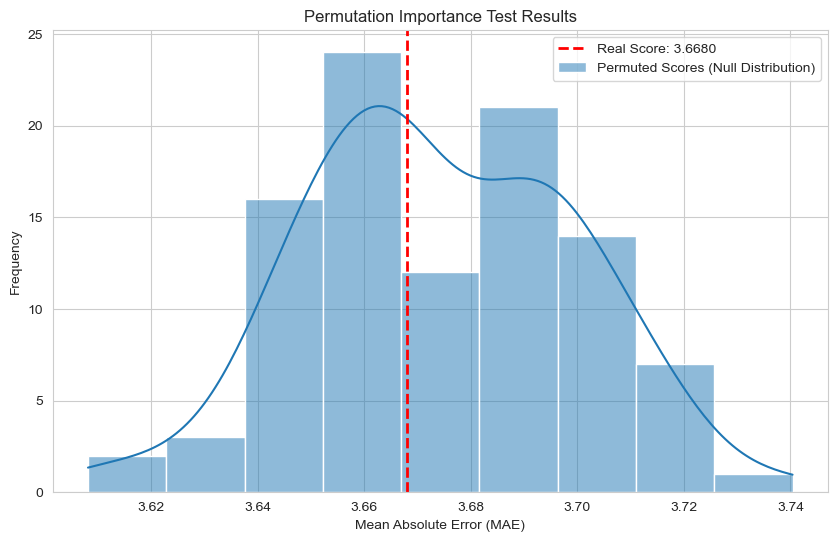


Result: The p-value is not less than 0.05. We fail to reject the null hypothesis.
This suggests that the model is not finding a statistically significant signal
in the proteomic features.


In [ ]:
real_average_mae = np.mean(real_averages)
p_value = np.mean(np.array(permuted_scores) <= np.mean(real_averages))


print("\n" + "="*50)
print("--- Hypothesis Test Conclusion ---")
print(f"Real Model Score (MAE): {real_average_mae:.4f}")
print(f"Mean Permuted Score (MAE): {np.mean(permuted_scores):.4f}")
print(f"P-value: {p_value:.4f}")
print("="*50)


plt.figure(figsize=(10, 6))
sns.histplot(permuted_scores, kde=True, label='Permuted Scores (Null Distribution)')
plt.axvline(real_average_mae, color='red', linestyle='--', linewidth=2, label=f'Real Score: {real_average_mae:.4f}')
plt.title('Permutation Importance Test Results')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

if p_value < 0.05:
    print("\nResult: The p-value is less than 0.05. We reject the null hypothesis.")
    print("This provides strong statistical evidence that the features")
    print("contain a significant predictive signal.")
else:
    print("\nResult: The p-value is not less than 0.05. We fail to reject the null hypothesis.")
    print("This suggests that the model is not finding a statistically significant signal")
    print("in the proteomic features.")


## Conclusion: 

### Observation: 

The score with the real data (MAE ≈ 3.67), falls directly in the middle of the blue histogram. There is no clear separation between the real score and the scores achieved by randomly permuting the biospecimen features.

### Analysis
Since the p-value is high, we cannot reject the null hypothesis, so we conclude that there is no statistically significant signals in the biospecimen features.